# Preprocessing

The preprocessing pipeline should output a list of speakers with quotes. Each element of this list should contain information about the speaker (full name, gender, date of birth...) - obtained from wikidata, and a string formed by joining multiple quotes in order to get a string of fixed length.

The pipeline is presented through a data analysis example - analysing the personalities of the US politicians. In this example we take 100 politicians from both of the two major political parties, the Democratic party and the Republican party. We select the politicians which have the most quotes in our database. We only consider quotes for which the probability of the speaker is higher than 80% (referenced as significant quotes in this notebook).

In [110]:
import bz2
import json
import re
import random
import sys
import os
import bz2
import time
import pandas as pd
import numpy as np
from functools import partial
import seaborn as sns
from helpers import *

In [ ]:
from IPython.display import Audio
sound_file = "D:/Music/I'm Shipping Up To Boston - Dropkick Murphys-x-64CaD8GXw.mp3"
# sound_file = "data/local_only/Car Alarm - QuickSounds.com.mp3"

In [ ]:
def play_sound():
    return Audio(sound_file, autoplay=True)

In [ ]:
play_sound()

### Counting significant quotes

<b>This step has been executed once and will not be needed in following analyses since the quote counts calculated are for all the speakers and the output can be simply reused.</b>

Define some methods for better reusability.

In [ ]:
PATTERN_INPUT = "../quotebank/quotes-{}.json.bz2"

In [ ]:
def write_json_to_file(name, obj):
    # Use current timestamp to make the name of the file unique
    millis = round(time.time() * 1000)
    name = f'{name}_{millis}.json'
    with open(name, 'wb') as f:
        output = json.dumps(obj)
        f.write(output.encode('utf-8'))
    return name

Method used for counting significant quotes.

In [ ]:
def check_if_significant_quote(row: dict, significant_quote_counters: dict) -> None:
    """Check if the quote for a given row can be considered significant for analysis and update
    the significancy dictionary.

    Args:
        row (dict): Row of data
        significant_quote_counters (dict): Dict to keep track of significant quotes
    """
    probabilities = row['probas']
    qids = row['qids']
    
    # Check if the probas and qids values exist
    if (len(probabilities) == 0 or len(qids) == 0):
        return
    
    # Check if the speaker is not 'Unknown'
    if (probabilities[0][0] == 'None'):
        return
    
    # Check if the probability is over 80%
    prob = float(probabilities[0][1])
    if (prob < 0.8):
        return
    
    # Increment count
    qid = qids[0]
    significant_quote_counters[qid] = significant_quote_counters.get(qid, 0) + 1

General method used for processing the quotes files.

In [ ]:
from typing import Callable

CHUNK_SIZE = 1_048_576

def process_compressed_json_file(input_file_name: str, output_name: str, year: int, process_json_object: Callable) -> str:
    """
    Read from a compressed file chunk by chunk. Decompress every chunk and try to decode it and parse it into an array of JSON objects.
    For each JSON object extracted this way, run the process_json_object function.
    In the end, a JSON object representing the result of this process is written into a file.

    Args:
        input_file_name (str): Name of the compressed json file which is the subject of processing.
        output_name (str): First part of the output file name. Used in creation of the full output file name: the year parameter and a timestamp are appended, as well as the .json extension.
        year (int): Represents the year for which the data in the input file is gathered, is appended to the output_name to generate the full output file name.
        process_json_object (Callable): Function that processes the individual JSON objects extracted from the compressed file. The signature should be as follows:
            Args:
                json_obj: JSON object which is to be processed.
                out_json: The output object in which the result of the processing is stored

    Returns:
        (str) Full name of the output JSON file.
    """
    # Decompression variables
    decompressor = bz2.BZ2Decompressor()
    
    # Decoding variables
    decoding_buffer = bytearray([])
    decoding_error_counter = 0
    
    # Parsing variables
    parsing_buffer = ''
    parsing_error_counter = 0
    
    # Progress variables - used to provide feedback to the dev
    input_size = os.path.getsize(input_file_name)
    start_time = time.time()
    total_in = 0
    total_out = 0
    previous_value = -1
    
    # Result of processing
    out_json = dict()
    
    # Iterate through the file
    with open(input_file_name, 'rb') as input_file:
        for chunk in iter(lambda: input_file.read(CHUNK_SIZE), b''):
            # Feed chunk to decompressor
            decompressed_chunk = decompressor.decompress(chunk)
            dec_chunk_length = len(decompressed_chunk)
            
            # Check the length of the decompressed data - 0 is common -- waiting for a bzip2 block
            if (dec_chunk_length == 0):
                continue
            
            # Try to decode byte array
            decoding_buffer += decompressed_chunk
            try:
                chunk_string = decoding_buffer.decode('utf-8')
                
                # Clear buffer
                decoding_buffer = bytearray([])
                
                decoding_successful = True
            except UnicodeDecodeError:
                # Error occurs when input stream is split in the middle of a character which is encoded with multiple bytes
                decoding_error_counter += 1
                decoding_successful = False
            
            # Try to parse the decoded string
            if decoding_successful:
                # Elements of the JSON array are split by '\n'
                array_elements = chunk_string.split('\n')
                
                # Iterate through the JSON array in the current chunk
                for json_candidate in array_elements:
                    # Try to parse the JSON object, might fail if the object was divided in parts because of the chunk separation
                    parsing_buffer += json_candidate
                    try:
                        json_obj = json.loads(parsing_buffer)
                        
                        # Clear buffer
                        parsing_buffer = ''
                        
                        parsing_successful = True
                    except ValueError:
                        """
                        Error occurs when the line does not contain the whole JSON object, which happens for the last array element in almost every chunk of input stream.
                        We solve this by remembering the prevous partial objects in parsing_buffer, and then merging it with the rest of the object when we load the next chunk.
                        """
                        parsing_error_counter += 1
                        parsing_successful = False
                    
                    # Perform JSON object processing
                    if parsing_successful:
                        process_json_object(json_obj, out_json)
            
            # Show progress
            total_in += len(chunk)
            total_out += dec_chunk_length
            if dec_chunk_length != 0:    # only if a bzip2 block emitted
                processed_fraction = round(1000 * total_in / input_size)
                if processed_fraction != previous_value:
                    left = (input_size / total_in - 1) * (time.time() - start_time)
                    print(f'\r{processed_fraction / 10:.1f}% (~{left:.1f}s left)\tyear: {year}\tnumber of entries: {len(out_json)}\tdecoding errors: {decoding_error_counter}\tparsing errors: {parsing_error_counter}', end='      ')
                    previous_value = processed_fraction
    
    # Save result to file
    output_full_name = write_json_to_file(f'{output_name}-{year}', out_json)
    
    # Report ending
    print()
    total_time = time.time() - start_time
    print(f'File {input_file_name} processed in {total_time:.1f}s', end='\n\n')
    
    return output_full_name

Create files for every year, each file contains a dictionary where the key is the QID of the speaker, and the value is the number of significant quotes.
<br><br>
<font color='red'>WARNING: LONG EXECUTION!</font>

In [ ]:
years = [2015, 2016, 2017, 2018, 2019, 2020]
# years = [2020]

output_list = []

for year in years:
    path_to_input = PATTERN_INPUT.format(year)
    
    # Process quote file
    output_name = process_compressed_json_file(path_to_input, 'data/signi-quote-count', year, check_if_significant_quote)
    
    output_list.append(output_name)

print('\n\nOutput file names:')
for file_name in output_list:
    print(file_name)

Now combine the quote counts into a single file.
<br>
An example of the file names is used, the string should be updated if the code is run again.

In [ ]:
signi_quotes_file_names = [
    "../quotebank/signi-quote-count-2015_1636244638891.json",
    "../quotebank/signi-quote-count-2016_1636246832187.json",
    "../quotebank/signi-quote-count-2017_1636249273913.json",
    "../quotebank/signi-quote-count-2018_1636250518608.json",
    "../quotebank/signi-quote-count-2019_1636251729971.json",
    "../quotebank/signi-quote-count-2020_1636237785105.json"
]

In [ ]:
combined_signi_dict = {}

for file_name in signi_quotes_file_names:
    with open(file_name, 'r') as f:
        one_dict = json.load(f)
        for k in one_dict.keys():
            combined_signi_dict[k] = combined_signi_dict.get(k, 0) + one_dict[k]

Sort the dictionary so the speakers with the most quotes appear first.

In [ ]:
sorted_combined_signi_dict = {k: v for k, v in sorted(combined_signi_dict.items(), key=lambda item: item[1], reverse=True)}

And finally save the resulting dictionary into a file, this file can later be reused for multiple analyses, whenever we need to choose a representation of a group of people using the number of quotes to pick the most quoted individuals.

In [ ]:
write_json_to_file('data/signi-quote-count-combined', sorted_combined_signi_dict)

Display the result.

In [ ]:
with open("data/local_only/signi-quote-count-combined_1636658426963.json", "r") as f:
    sorted_combined_signi_dict = json.load(f)

In [ ]:
pd.DataFrame(sorted_combined_signi_dict.items(), columns=['ID', 'Number of quotes']).head()

### Get the wikidata

We used the https://query.wikidata.org/ website to get the relevant wikidata. The SPARQL query is in the following cell.
<br>
We can do this (and did do afterwards) using the provided wikidata parquet file as well.

In [ ]:
SELECT DISTINCT ?item ?itemLabel 
          ?genderLabel ?citizenshipLabel ?languageLabel ?religionLabel ?ethnicLabel ?degreeLabel
          ?dateOfBirth ?placeOfBirthLabel 
#           ?nativeNameLabel ?birthNameLabel ?givenNameLabel ?familyNameLabel ?pseudonymLabel 
#           ?fatherLabel ?motherLabel ?siblingLabel ?spouseLabel ?childLabel ?numOfChild 
#           ?occupationLabel ?positionLabel ?ideologyLabel ?educatedAtLabel
          ?memberOfParty ?memberOfPartyLabel 
WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    ?item p:P106 ?statement0.
    ?statement0 (ps:P106) wd:Q82955.
    {
      ?item p:P102 ?statement1.
      ?statement1 (ps:P102) wd:Q29552.
    }
    UNION
    {
      ?item p:P102 ?statement2.
      ?statement2 (ps:P102) wd:Q29468.
    }
    MINUS {
      ?item p:P570 ?statement_3.
      ?statement_3 psv:P570 ?statementValue_3.
      ?statementValue_3 wikibase:timePrecision ?precision_3.
      FILTER(?precision_3 >= 11 )
      ?statementValue_3 wikibase:timeValue ?P570_3.
      FILTER(?P570_3 < "+2015-01-01T00:00:00Z"^^xsd:dateTime)
    }
    OPTIONAL { ?item wdt:P21 ?gender. }
    OPTIONAL { ?item wdt:P27 ?citizenship. }
    OPTIONAL { ?item wdt:P103 ?language. }
    OPTIONAL { ?item wdt:P140 ?religion. }
    OPTIONAL { ?item wdt:P172 ?ethnic. }
    OPTIONAL { ?item wdt:P512 ?degree. }
    
    OPTIONAL { ?item wdt:P569 ?dateOfBirth. }
    OPTIONAL { ?item wdt:P19 ?placeOfBirth. }
    
#     OPTIONAL { ?item wdt:P1559 ?nativeName. }
#     OPTIONAL { ?item wdt:P1477 ?birthName. }
#     OPTIONAL { ?item wdt:P735 ?givenName. }
#     OPTIONAL { ?item wdt:P734 ?familyName. }
#     OPTIONAL { ?item wdt:P742 ?pseudonym. }
    
#     OPTIONAL { ?item wdt:P22 ?father. }
#     OPTIONAL { ?item wdt:P25 ?mother. }
#     OPTIONAL { ?item wdt:P3373 ?sibling. }
#     OPTIONAL { ?item wdt:P26 ?spouse. }
#     OPTIONAL { ?item wdt:P40 ?child. }
#     OPTIONAL { ?item wdt:P1971 ?numOfChild. }
    
#     OPTIONAL { ?item wdt:P106 ?occupation. }
#     OPTIONAL { ?item wdt:P39 ?position. }
#     OPTIONAL { ?item wdt:P1142 ?ideology. }
#     OPTIONAL { ?item wdt:P69 ?educatedAt. }
    
    OPTIONAL { ?item wdt:P102 ?memberOfParty. }
  }
}

Merge duplicate objects representing a single speaker but with differing fields.
<br>
Example: Arnold Schwarzenegger has both Austrian and American nationalities, and would appear twice, once with Austrian, and once with American nationality.

In [ ]:
with open("data/local_only/suicide_query_and_hangings_and_after_2015.json", "r", encoding='utf-8') as f:
    suicide_squad = json.load(f)

In [ ]:
suicide_squad_merged = dict()

index = 0
for row in suicide_squad:
    # Extract the QID from the link (ex. http://www.wikidata.org/entity/Q203286 -> Q203286)
    qid_start = row['item'].rindex('/') + 1
    key = row['item'][qid_start:]
    # Replace the link with the QID
    row['item'] = key
    
    if key in suicide_squad_merged:
        merged_entry = suicide_squad_merged[key]
        columns = ['itemLabel', 'genderLabel', 'citizenshipLabel', 'religionLabel', 'ethnicLabel', 'degreeLabel', 'dateOfBirth', 'placeOfBirthLabel', 'memberOfParty', 'memberOfPartyLabel', 'languageLabel']
        """
        Merge the values for every column:
            - if the values are the same - do nothing
            - if the values are different - create a list and add them both
        """
        for col in columns:
            if row.get(col, None) is None:
                continue
                
            updated_entry = merged_entry.get(col, None)
            
            if updated_entry is None:
                updated_entry = row[col]
            elif isinstance(updated_entry, list):
                if row[col] not in updated_entry:
                    updated_entry.append(row[col])
            elif row[col] != updated_entry:
                updated_entry = [updated_entry, row[col]]
                
            merged_entry[col] = updated_entry
    else:
        suicide_squad_merged[key] = row

In [ ]:
write_json_to_file('data/local_only/suicide_list_merged', suicide_squad_merged)

Alternatively, we can query the wikidata parquet file.

In [ ]:
speakers = pd.read_parquet('data/speaker_attributes.parquet')
play_sound()

In [ ]:
from helpers import to_datetime
import datetime

DEMOCRATIC_PARTY_QID = 'Q29552'
REPUBLICAN_PARTY_QID = 'Q29468'
POLITICIAN_QID = 'Q82955'
party_match = speakers.party.apply(lambda p: DEMOCRATIC_PARTY_QID in p or REPUBLICAN_PARTY_QID in p if p is not None else False)
occupation_match = speakers.occupation.apply(lambda o: POLITICIAN_QID in o if o is not None else False)
dob_match = speakers.date_of_birth.apply(lambda d: to_datetime(d[0]) > datetime.date(1900, 1, 1) if d is not None else False)
american_politicians = speakers[party_match & occupation_match & dob_match]

play_sound()

In [ ]:
american_politicians.to_json('data/american_politicans_parquet.json', orient='records')

In [ ]:
wiki_poli_parquet = json.loads(american_politicians.to_json(orient='records'))

wiki_poli_merged = dict()
for poli in wiki_poli_parquet:
    wiki_poli_merged[poli['id']] = poli

### Get the 100 most quoted party members

In [ ]:
with open("data/local_only/suicide_list_merged_1638730998799.json", "r", encoding='utf-8') as f:
    suicide_merged = json.load(f)

In [ ]:
suicide_df = pd.DataFrame.from_dict(suicide_merged, orient='index')

In [ ]:
suicide_df.head()

Using the results of the previous two steps - the number of quotes for each speaker, and the list of US politicians, we can compile a list of 100 most quoted members of the two major US political parties.

In [ ]:
dem_list = []
rep_list = []

suicide100 = []

CAP_TARGET = 100
DEM_PARTY = 'Q29552'
REP_PARTY = 'Q29468'

for v in sorted_combined_signi_dict:
    row = suicide_merged.get(v, None)
    
    # Could not find person in the politician dictionary
    if row is None:
        continue
        
    # Append to list
    suicide100.append(row)
    
    # Check if lists are at full capacity
    if len(suicide100) == CAP_TARGET:
        break

In [ ]:
sorted_combined_signi_dict.get('Q15521785', -1)

Display the list of politicians.

In [ ]:
BOLD = '\033[1m'
END = '\033[0m'
print(BOLD + f'{"":3} {"People that commited suicide":62}' + END)
print(BOLD + f'{"":3} {"Name":30} {"ID":10} {"Number of quotes":20}' + END)

for index in range(100):
    row = suicide100[index]
    
    v = row['itemLabel']
    q = row['item']
    c = str(sorted_combined_signi_dict.get(q, -1))
    
    print(f"{index + 1:3} {v:30} {q:10} {c:20}")
#     print(row)
    
    index += 1
    if index % 10 == 0:
        print()

### Get the politician quotes

For the politicians in the previously compiled lists, we now fetch the quotes from the quote files. We use the methods defined at the top of this notebook, which were written in a reusable way.

In [ ]:
def check_if_party_member_quote(row: dict, party_member_quotes: dict, party_list: list) -> None:
    """CHeck if party member quote is useful for analysis

    Args:
        row (dict): Row of data
        party_member_quotes (dict): Dict to keep track of party member quotes
        party_list (list): Party list
    """
    probabilities = row['probas']
    qids = row['qids']
    
    # Check if the probas and qids values exist
    if (len(probabilities) == 0 or len(qids) == 0):
        return
    
    # Check if the speaker is not 'Unknown'
    if (probabilities[0][0] == 'None'):
        return
    
    # Check if the probability is over 80%
    p = float(probabilities[0][1])
    if (p < 0.8):
        return
    
    # Check if the speaker is on the party list
    qid = qids[0]
    if qid not in party_list:
        return
    
    # Remember only the quote and the probability
    data = {}
    data['quotation'] = row['quotation']
    data['proba'] = row['probas'][0][1]
    
    # Append the quote
    arr = party_member_quotes.get(qid, [])
    arr.append(data)
    party_member_quotes[qid] = arr

In [ ]:
# Join both party lists
# dem_and_rep_set = set()    
# for v in dem_list:
#     dem_and_rep_set.add(v['id'])
# for v in rep_list:
#     dem_and_rep_set.add(v['id'])
suicide_set = set()
for v in suicide100:
    suicide_set.add(v['item'])

# Define partial function check_if_dem_or_rep_quote using function check_if_party_member_quote
check_if_dem_or_rep_quote = partial(check_if_party_member_quote, party_list=suicide_set)

Create files for every year, each file contains a dictionary where the key is the QID of the speaker, and the value is the list of significant quotes attributed to the speaker.
<br><br>
<font color='red'>WARNING: LONG EXECUTION!</font>

In [ ]:
# years = [2015, 2016, 2017, 2018, 2019, 2020]
years = [2018, 2019, 2020]
# years = [2020]

output_list = []

for year in years:
    path_to_input = PATTERN_INPUT.format(year)
    
    # Process quote file
    output_name = process_compressed_json_file(path_to_input, 'data/suicide-quotes', year, check_if_dem_or_rep_quote)
    
    output_list.append(output_name)

print('\n\nOutput file names:')
for file_name in output_list:
    print(file_name)

play_sound()

### Combine the quotes and the wikidata

Now we combine the politician quotes with their wikidata information. We use the 6 files of politician quotes created in the previous step, as well as the list of the party members. The result is a file which contains 200 entries, where each entry represents one politician, and contains their wikidata info as well as a list of quotes. The list of quotes can be quite long for some of the politicians.

In [ ]:
poli_quote_files = [
    "../quotebank/politician-quotes-2015_1636331534906.json",
    "../quotebank/politician-quotes-2016_1636332058163.json",
    "../quotebank/politician-quotes-2017_1636333168732.json",
    "../quotebank/politician-quotes-2018_1636334221167.json",
    "../quotebank/politician-quotes-2019_1636335010497.json",
    "../quotebank/politician-quotes-2020_1636330658142.json"
]

suicide_quote_files = [
    "data/local_only/suicide-quotes-2015_1638733582656.json",
    "data/local_only/suicide-quotes-2016_1638734492424.json",
    "data/local_only/suicide-quotes-2017_1638736277871.json",
    "data/local_only/suicide-quotes-2018_1638738456963.json",
    "data/local_only/suicide-quotes-2019_1638739764361.json",
    "data/local_only/suicide-quotes-2020_1638740031014.json"
]

poli_quotes_combined = {}
suicide_quotes_combined = {}

both_parties = dem_list + rep_list
for v in suicide100:
    copy = dict(v)
    copy['quotations'] = []
    
    suicide_quotes_combined[v['item']] = copy

for file_name in suicide_quote_files:
    with open(file_name, 'r', encoding='utf-8') as f:
        quotes = json.load(f)
        
        for k in quotes.keys():
            suicide_quotes_combined[k]['quotations'] += quotes[k]

write_json_to_file('data/local_only/suicide-quotes-combined', suicide_quotes_combined)

### Filter the quotes

Some of the quotes in the database do not represent actual quotes, but instead contain junk like html tags, source code, or text from the webpage where the source article was published.
<br>
We filter these quotes out so our dataset is not polluted by junk data. We have found a few filters which detect most of the junk data, while maintaining a low false positive rate:
<ul>
    <li>quotes which contains very long 'words' - more than 50 characters</li>
    <li>quotes which contain URLs - these usually contain other junk characters</li>
    <li>quotes which contains JSON-like key-value pairs</li>
    <li>quotes which contain a lot of special characters (more than 10% of total characters)</li>
</ul>

In [ ]:
with open('data/local_only/suicide-quotes-combined_1638812771469.json', 'r', encoding='utf-8') as f:
    suicide_quotes_filtered = json.load(f)

In [ ]:
filtered_quotes = []

weird_pattern = '[_@#+&;:\(\)\{\}\[\]\\/`]'
json_pattern = '\{.*[a-zA-Z]+:\s[\'"`][a-zA-Z0-9]+[\'"`].*\}'
url_pattern = 'https?'

for k in suicide_quotes_filtered.keys():
    elem = suicide_quotes_filtered[k]
    
    new_arr = []
    for entry in elem['quotations']:
        text = entry['quotation']
        
        longest = max(entry['quotation'].split(), key=len)
        if (len(longest) > 50):
            filtered_quotes.append(entry)
            continue
        
        if re.search(url_pattern, text) is not None:
            filtered_quotes.append(entry)
            continue
        
        if re.search(json_pattern, text) is not None:
            filtered_quotes.append(entry)
            continue
            
        weird_num = len(re.findall(weird_pattern, text))
        total = len(text)
        weird_percent = weird_num / total
        if (weird_percent > 0.1):
            filtered_quotes.append(entry)
            continue
            
        new_arr.append(entry)
    elem['quotations'] = new_arr

In [ ]:
write_json_to_file('data/local_only/suicide-quotes-combined-and-filtered', suicide_quotes_filtered)

Show some filtered quotes:

In [ ]:
for entry in filtered_quotes[0:5]:
    print(entry['quotation'], end='\n\n')

### Concatenate the quotes

Finally, we concatenate the quotes into a single fixed-length string. We do this because of the limitation of the CSV file format, which can contains at most ~32000 characters in a single field. This means that most of the quotes will not be used.
<br>
Alternatively, we could use multiple fields for the same speaker, but we think the amount of characters that can fit in a single cell is enough for a decent analysis.
<br>
We sort the quotes by length and use the longest ones first. We do this because the longer quotes are a better representation of a person's speach.

In [ ]:
with open('data/local_only/suicide-quotes-combined-and-filtered_1638812964192.json', 'r', encoding='utf-8') as f:
    suicides_quotes_concat = json.load(f)

In [ ]:
QUOTE_LENGTH = 5000

index = 1
for k in suicides_quotes_concat.keys():
    elem = suicides_quotes_concat[k]
    
    # Sort the quotes by length
    elem['quotations'].sort(key = lambda x: len(x['quotation']), reverse = True)
    
    concat = ''
    printed = False
    for quote in elem['quotations']:
        # Concatenate the quotes
        concat += ' ' + quote['quotation']
        
        # Trim if we are over QUOTE_LENGTH
        if (len(concat) >= QUOTE_LENGTH):
            print(f'{index:5} {len(quote["quotation"]):5} {quote["quotation"]}')
            index += 1
            printed = True
            
            if index % 10 == 1:
                print()
            
            concat = concat[0:QUOTE_LENGTH]
            break
    
    if printed == False:
        quote = elem['quotations'][-1]
        print(f'{index:5} {len(quote["quotation"]):5} {quote["quotation"]}')
        index += 1
        
        if index % 10 == 1:
            print()
    elem['quotations'] = concat

In [ ]:
write_json_to_file('data/local_only/suicide-quotes-concatenated', suicides_quotes_concat)

In [ ]:
pd.DataFrame(suicides_quotes_concat.values()).head()

In [ ]:
for index, elem in enumerate(suicides_quotes_concat.values()):
#     print(elem)
    print(f'{index + 1:5} {elem["item"]:15} {len(elem["quotations"]):10}')

In [ ]:
CUTOFF = 60

suicides_quotes_final = dict()
for index, key in enumerate(suicides_quotes_concat):
    if index == CUTOFF:
        break
    
    suicides_quotes_final[key] = suicides_quotes_concat[key]

In [ ]:
for index, elem in enumerate(suicides_quotes_final.values()):
#     print(elem)
    print(f'{index + 1:5} {elem["item"]:15} {len(elem["quotations"]):10}')

In [ ]:
write_json_to_file('data/local_only/suicide-quotes-top-60', suicides_quotes_final)

## Initial Data Analysis

In [8]:
import bz2
import json
import pandas as pd
import csv

In [ ]:
# Load the concatenated quotes for top 100 politician
with open('data/local_only/suicide-quotes-top-60_1638815474527.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

After getting the data, we extract the quote ID and the concatenated quote of each politician, and write them to `input_data1.csv` for the LIWC personality analysis.

In [ ]:
with open('data/local_only/sui_input_data_1.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["qid", "quote"])
    for qid, all_value in data.items():
        quote = all_value["quotations"]
        writer.writerow([qid, quote])

### LIWC Analysis
After parsing the `input_data1.csv` using the liwc software (Academic Version), for each concatenated quote, it gains a list of features in terms of LIWC categories, such as pronoun, articles. We save the data as `output_data1.csv` and then load it to our notebook.

In [ ]:
liwc = pd.read_csv('data/local_only/sui_output_1.csv')

In [ ]:
# Visualise a random sample
liwc.sample()

In [ ]:
poli_liwc = pd.read_csv('data/output_data1.csv')

In [ ]:
poli_liwc.sample()

### Personality Analysis Based on LIWC Results
According to the research by Tal Yarkoni from University of Colorado at Boulder, significant correlations between LIWC categories and the big five personalities are identified based on a large scale analysis (2010). Hence, we create the `predict_personality()` function which interpret the correlation coefficients as scores and allows us to select the features based on the recorded significant level from the research.

In [10]:
from helpers import LIWC_OCEAN_MAP

def predict_personality(liwc_data: pd.DataFrame, sig_level: int = 1) -> pd.DataFrame:
    """Predicts personality based on the LIWC metrics.
    This function computes personality scores based on the LIWC features. It essentially multiplies the matrix of normalized LIWC
    features with the matrix of correlations between LIWC and Big-Five personality types. 
    
    More specifically, here liwc_data is of dimension (N, D) where N is the number of samples (e.g. quotes for speakers) and
    D is the number LIWC features/categories (e.g. first_person_pronoun, negation etc. full list of categories and their descriptions
    can be found in the LIWC manual https://www.researchgate.net/publication/228650445_The_Development_and_Psychometric_Properties_of_LIWC2007)
    The correlations matrix on the other hand is of dimensions (D, K) where K is the number of extended BigFive personality categories 
    (e.g. neuroticism, depression, friendliness etc.) The significance level of these correlations can be also customized using the
    sig_level parameter which ranges between 0 and 3 where 0 means use all the correlations, 1 means use only those with p < 0.05,
    2 means use those with p < 0.01 and 3 means use those with p < 0.001.

    Args:
        liwc_data (pd.DataFrame): LIWC metrics data
        sig_level (int, optional): Significance level. Defaults to 1 (i.e. p < 0.05)

    Returns:
        pd.DataFrame: Personality scores
    """
    # Load LIWC-OCEAN correlations matrix
    liwc_ocean_data = pd.read_csv('data/LIWC_OCEAN.csv', index_col=0)

    # Load significancy level matrix for LIWC-OCEAN (of the same dimension as the correlations matrix)
    liwc_ocean_sig_data = pd.read_csv('data/LIWC_OCEAN_Significance.csv', index_col=0)

    # Rename LIWC features data columns to match correlations index names
    liwc_data = liwc_data[list(LIWC_OCEAN_MAP.keys())].rename(columns=LIWC_OCEAN_MAP)

    # Normalize LIWC features to be between 0 and 1
    liwc_data = liwc_data.div(liwc_data.sum(axis=1), axis=0)

    # Verify that the column names and index names match for matrix multiplication
    assert (liwc_ocean_data.index == liwc_data.columns).all()

    # Filter correlations by significance level
    liwc_ocean_data_with_sig = liwc_ocean_data * (liwc_ocean_sig_data >= sig_level).astype(int)

    # Compute personality scores
    return liwc_data.dot(liwc_ocean_data_with_sig)

In [ ]:
personality = predict_personality(liwc)

In [ ]:
personality.sample()

In [ ]:
# concat the liwc output to the personality result
df1 = pd.concat([liwc, personality], axis=1)
df1.sample()

In [ ]:
poli_personality = predict_personality(poli_liwc)
poli_df1 = pd.concat([poli_liwc, poli_personality], axis=1)

In [ ]:
# load the top 100 politician data, queried from wikidata, concat with current dataset.
with open('./data/top100_politicians_by_party.json', 'r') as f:
    data_top100 = json.load(f)

dem_df = pd.DataFrame(data_top100["dem"])
rep_df = pd.DataFrame(data_top100["rep"])
dem_df['party'] = "dem"
rep_df['party'] = "rep"
politician_wiki = pd.concat([dem_df, rep_df])
poli_df2 = poli_df1.merge(politician_wiki, left_on='Source (A)', right_on='item', how = "left")
poli_df2.sample()

In [ ]:
sui_wiki = pd.DataFrame(data.values())
df2 = df1.merge(sui_wiki, left_on='Source (A)', right_on='item', how='left')
df2.sample()

In [ ]:
# df2[['item', 'itemLabel', 'genderLabel', 'citizenshipLabel', 'religionLabel', 'dateOfBirth', 'quotations']].head()
df2.head()

In [ ]:
df2_copy = df2.copy()
df2_copy['suicide'] = "Yes"
print(df2_copy.shape[0])

poli_df2_copy = poli_df2.copy()
poli_df2_copy['suicide'] = "No"
poli_df2_copy = poli_df2_copy.head(60)
print(poli_df2_copy.shape[0])

In [ ]:
combdf = pd.concat([df2_copy, poli_df2_copy]).reset_index()

In [ ]:
# from helpers import PERSONALITY_ATTRS

for i, attr in enumerate(PERSONALITY_ATTRS):
    sns.displot(combdf, x=attr, hue='suicide', kind='kde')

## Basic Analysis

For this part, we use the programming language R to get better visualisation and embed the output in html from knitting the our Rmarkdown document.

In [ ]:
means = df2[list(LIWC_OCEAN_MAP.keys())].mean()
# for mean in means:
#     print(mean)

for i in range(len(means)):
    print(f'{means.keys()[i]:10} {means[i]:10.2f}')

### Comparing the Personality of Politicians from Democratic and Republic Parties

We compare each characteristic for democratic and republic politicians using Wilcoxon rank sum test, which tests whether top politicians from different parties have the equal medians for each attribute. The reason for choosing Wilcoxon rank sum over two sample t test is that we do not know the distribution of the characteristic values and Wilcoxon does not assume known distributions.

In [ ]:
## R codes
library(gtsummary)
library(dplyr)
df = read.csv("concats")
df_personality_party <-  df %>% select(c(87:121, 134)) # 87:121 contains all personalities, 123 is name, 134 is party
df_personality_party %>% tbl_summary(by = party) %>% add_p()

<img src="./data/my_table.png" alt="drawing" width="600" align="left">

The current result shows that the only significant differences are artistic_interests and emotionality, where democratic politicians have higher average artistic_interests and emotionality compared to republic politicians.

### Comparing Main Politicians in US Based on Their Personality

We use interactive heatmap in r to produce the following map. By clicking on the specific cell, you can see the value of each attribute for the person and compare it to other politicians. When a cell is blue, it means a positive value with regards to that attribute. When it is red, it gives a negative value for the correponding characteristic. We can compare the value of each cell easily by looking at the color gradient, i.e. the deeper the color, the larger the absolute value.

Moreover, by selecting several cells, you are able to zoom in to see difference in details. To go back to the original view, please double click the plot.

In [ ]:
# Notes: Interactive heatmap will show up once you run the following code chunk. It will not show up directly
# on Github since it does not support interactive map.
from IPython.display import IFrame
IFrame(src='./data/section-2.html', width=700, height=600)

In [ ]:
## R codes
library(d3heatmap)

df2 <- df %>% select(c(123, 87:121))
rownames(df2) <- df2$itemLabel
df2 <- df2 %>% select(-itemLabel)

df_several <- df2[c("Barack Obama", "Hillary Clinton", "Joe Biden", "Elizabeth Warren", "Andrew Cuomo", "Donald Trump", "Lindsey Graham", "George W. Bush"),] 
rownames(df_several) <- c("B. Obama", "H. Clinton", "J. Biden", "E. Warren", "A. Cuomo", "D. Trump", "L. Graham", "G. W. Bush")
d3heatmap(scale(df_several), colors = "RdYlBu",
          k_row = 4, # Number of groups in rows
          k_col = 2, # Number of groups in columns
          scale = "column"
          )

<img src="./data/heatmap.png" alt="drawing" width="700" align="left">

On the plot above, similar people will be scattered together. For example,
- Barack Obama and George W. Bush have similar personalities based on their quotations. 
- Donald Trump and Lindsey Graham are quite close on most scales of personality. 
- Obama and Trump seem to have opposite personality.
- A few more details: 
  - Trump has high depression and low orderliness
  - Bush has high assertiveness, extraversion and low hostility, neuroticism, anxiety
  - Obama has high emotionality
  - Biden has high modesty, morality, trust, cautiousness and low excitement seeking

<br/><br/><br/>
Bourdain is #1027 if we go by number of significant quotes.<br/>
This means we can use the top1000 list as control without any changes.

# NEW START

### LIWC output

In [2]:
sui_liwc = pd.read_csv('data/local_only/sui_output_1.csv')

In [3]:
# Visualise a random sample
sui_liwc.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
44,Q10900554,Despite this independent assessment after a l...,848,25.7,24.65,67.33,10.85,5.54,1.89,7.43,...,3.89,0.0,0.0,0.0,0.0,0.47,0.0,1.53,0.47,0.12


In [4]:
ctrl_liwc = pd.read_csv('data/top_1000_output_1.csv')

In [5]:
ctrl_liwc.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
388,Q1173911,It's nearly five years since we came to offic...,828,28.55,23.31,61.59,4.35,0.0,1.69,1.69,...,3.86,1.93,0.97,0.36,0.0,1.57,0.0,3.26,0.0,0.6


In [46]:
poli_liwc = pd.read_csv('data/output_data1.csv')

In [47]:
poli_liwc.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
44,Q22260,I have been thorough in examining Judge Kavan...,853,28.43,24.97,67.64,9.85,3.05,0.7,3.75,...,3.05,0.0,0.0,0.0,0.0,0.82,0.0,3.87,0.0,0.47


### Personality

In [25]:
sui_personality = predict_personality(sui_liwc)

In [26]:
ctrl_personality = predict_personality(ctrl_liwc)

In [48]:
poli_personality = predict_personality(poli_liwc)

### Wikidata

In [6]:
with open('data/local_only/suicide-quotes-top-60_1638815474527.json', 'r', encoding='utf-8') as f:
    sui_wikidata = json.load(f)

In [11]:
with open('data/local_only/top-1000-quotes-concatenated_1638964313725.json', 'r', encoding='utf-8') as f:
    ctrl_wikidata = json.load(f)

In [49]:
with open('data/politician-quotes-concatenated_1636411537251.json', 'r', encoding='utf-8') as f:
    poli_wikidata = json.load(f)

### Merge LIWC and Wikidata

In [27]:
df1 = pd.concat([sui_liwc, sui_personality], axis=1)
sui_wikidata_pd = pd.DataFrame(sui_wikidata.values())

sui_df = df1.merge(sui_wikidata_pd, left_on='Source (A)', right_on='item', how='left')
sui_df.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,genderLabel,citizenshipLabel,languageLabel,religionLabel,ethnicLabel,dateOfBirth,placeOfBirthLabel,quotations,memberOfParty,memberOfPartyLabel
39,Q463840,We are thrilled that Thriller Live goes from ...,870,24.86,23.56,69.66,7.01,0.46,2.64,3.1,...,male,United Kingdom,NaN,NaN,NaN,1964-06-06T00:00:00Z,Jersey,We are thrilled that Thriller Live goes from ...,NaN,NaN


In [28]:
df1 = pd.concat([ctrl_liwc, ctrl_personality], axis=1)
ctrl_wikidata_pd = pd.DataFrame(ctrl_wikidata.values())

ctrl_df = df1.merge(ctrl_wikidata_pd, left_on='Source (A)', right_on='item', how='left')
ctrl_df.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,item,itemLabel,genderLabel,citizenshipLabel,religionLabel,dateOfBirth,quotations,languageLabel,ethnicLabel,degreeLabel
312,Q713383,Nashville has really taken on a life of its o...,958,17.42,11.59,84.13,15.76,1.15,4.18,5.32,...,Q713383,Peter Laviolette,male,United States of America,NaN,1964-12-07T00:00:00Z,Nashville has really taken on a life of its o...,NaN,NaN,NaN


In [50]:
df1 = pd.concat([poli_liwc, poli_personality], axis=1)
poli_wikidata_pd = pd.DataFrame(poli_wikidata.values())

poli_df = df1.merge(poli_wikidata_pd, left_on='Source (A)', right_on='item', how='left')
poli_df.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,citizenshipLabel,languageLabel,religionLabel,ethnicLabel,degreeLabel,dateOfBirth,placeOfBirthLabel,memberOfParty,memberOfPartyLabel,quotations
50,Q516515,I think the likelihood of a BRAC will be depe...,842,22.16,26.13,68.29,7.36,1.54,2.73,4.28,...,United States of America,NaN,Baptists,NaN,NaN,1939-06-14T00:00:00Z,New York City,http://www.wikidata.org/entity/Q29552,Democratic Party,I think the likelihood of a BRAC will be depe...


### Merge into one dataframe for side-by-side comparison

In [40]:
sui_df_copy = sui_df.copy()
sui_df_copy['suicide'] = "Yes"
print(sui_df_copy.shape[0])

ctrl_df_copy = ctrl_df.copy()
ctrl_df_copy['suicide'] = "No"
# ctrl_df_copy = ctrl_df_copy.head(60)
print(ctrl_df_copy.shape[0])

60
1000


In [41]:
combdf = pd.concat([sui_df_copy, ctrl_df_copy]).reset_index()

In [51]:
poli_df_copy = poli_df.copy()
poli_df_copy['politician'] = "Yes"
print(poli_df_copy.shape[0])

ctrl_df_copy = ctrl_df.copy()
ctrl_df_copy['politician'] = "No"
# ctrl_df_copy = ctrl_df_copy.head(60)
print(ctrl_df_copy.shape[0])

200
1000


In [52]:
comb2df = pd.concat([poli_df_copy, ctrl_df_copy]).reset_index()

### Analysis

In [61]:
import seaborn as sns
from helpers import PERSONALITY_ATTRS
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [156]:
test3 = sui_df.copy()
test3['speaker'] = test3['itemLabel']
test3 = test3[test3['item'].isin(['Q426582', 'Q45864', 'Q505476'])].set_index('speaker')

In [157]:
test4 = test3[PERSONALITY_ATTRS]

In [158]:
means = ctrl_df[PERSONALITY_ATTRS].mean()
stds = ctrl_df[PERSONALITY_ATTRS].std()
test4 = (test4 - means) / stds
# srs = pd.Series(ctrl_df[PERSONALITY_ATTRS].mean(), name='average')
# test4 = test4.append(srs)

<AxesSubplot:title={'center':'Normalized personality factors'}, ylabel='speaker'>

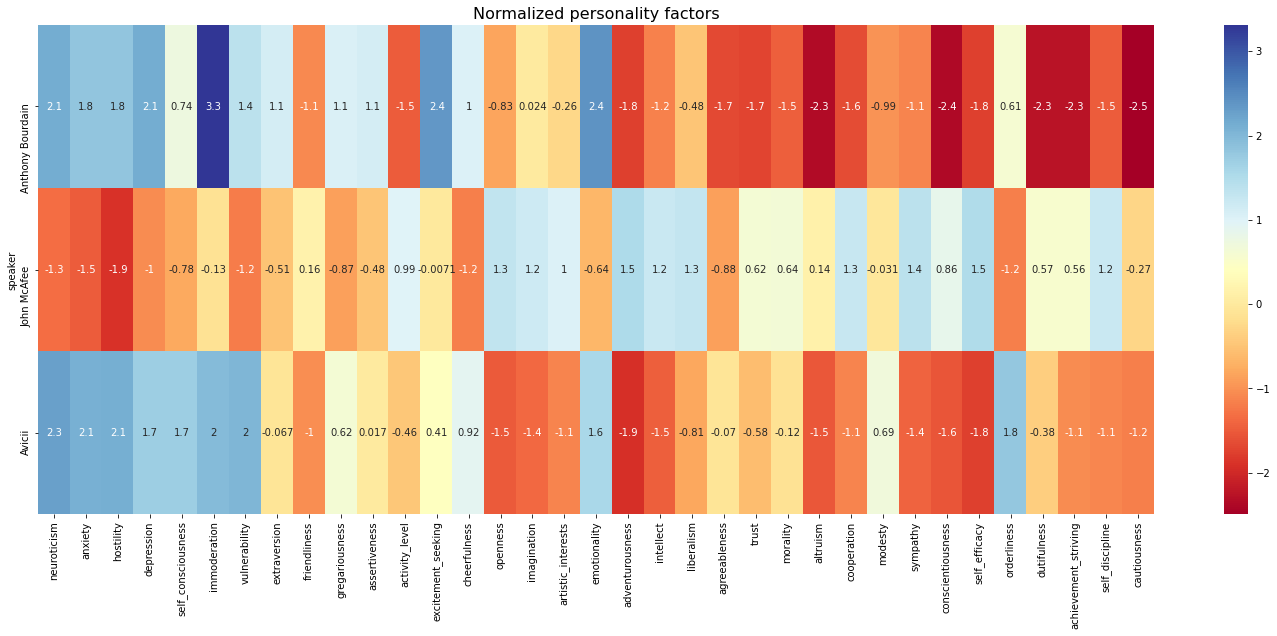

In [165]:
fig, ax = plt.subplots(figsize=(25, 9))
ax.set_title('Normalized personality factors', fontsize='16')
sns.heatmap(test4, ax=ax, annot=True, cmap='RdYlBu')

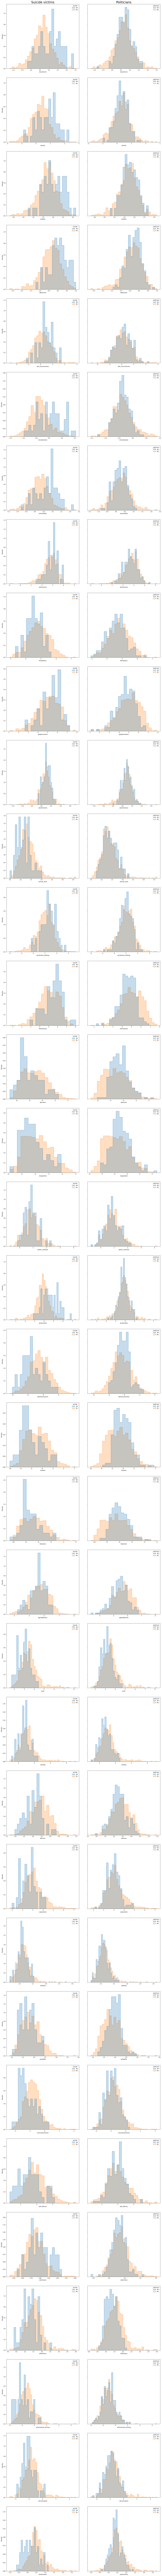

In [109]:
subset = PERSONALITY_ATTRS

fig, axs = plt.subplots(len(subset), 2, figsize=(18.5, len(subset) * 8), sharey='row')
# fig.set_size_inches(18.5, len(subset) * 8)
fig.tight_layout(pad=5.0)
axs[0][0].set_title('Suicide victims', fontsize=24)
axs[0][1].set_title('Politicians', fontsize=24)

for i, attr in enumerate(subset):
    sns.histplot(combdf, x=attr, hue='suicide', element="step", stat="density", common_norm=False, ax=axs[i][0])
    sns.histplot(comb2df, x=attr, hue='politician', element="step", stat="density", common_norm=False, ax=axs[i][1])